In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [4]:
data=pd.read_csv("Stock-10.csv")
data

,Date,Log Stock Price,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
0,1/31/2010,6.979024,14.629292,6.825715,0.110000,-33.735952
1,2/28/2010,7.007139,14.634155,6.832180,0.126429,-33.730959
2,3/31/2010,7.064272,14.647630,6.837907,0.164516,-34.859550
3,4/30/2010,7.078923,14.660837,6.840604,0.198333,-34.968581
4,5/31/2010,6.993392,14.664293,6.843189,0.200645,-31.492259
...,...,...,...,...,...,...
135,4/30/2021,8.338346,15.866549,7.675462,0.069000,-2.827729
136,5/31/2021,8.343818,15.878174,7.681530,0.058065,-1.116398
137,6/30/2021,8.365789,15.898266,7.686549,0.078000,-1.093716
138,7/31/2021,8.388282,15.918468,7.689882,0.098065,0.611392


In [5]:
data = data.set_index('Date')
data

,Log Stock Price,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
1/31/2010,6.979024,14.629292,6.825715,0.110000,-33.735952
2/28/2010,7.007139,14.634155,6.832180,0.126429,-33.730959
3/31/2010,7.064272,14.647630,6.837907,0.164516,-34.859550
4/30/2010,7.078923,14.660837,6.840604,0.198333,-34.968581
5/31/2010,6.993392,14.664293,6.843189,0.200645,-31.492259
...,...,...,...,...,...
4/30/2021,8.338346,15.866549,7.675462,0.069000,-2.827729
5/31/2021,8.343818,15.878174,7.681530,0.058065,-1.116398
6/30/2021,8.365789,15.898266,7.686549,0.078000,-1.093716


C:\Users\proma.gupta\Desktop\jupyter_practice\ML Tutorial\Updated\datlib\plots.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


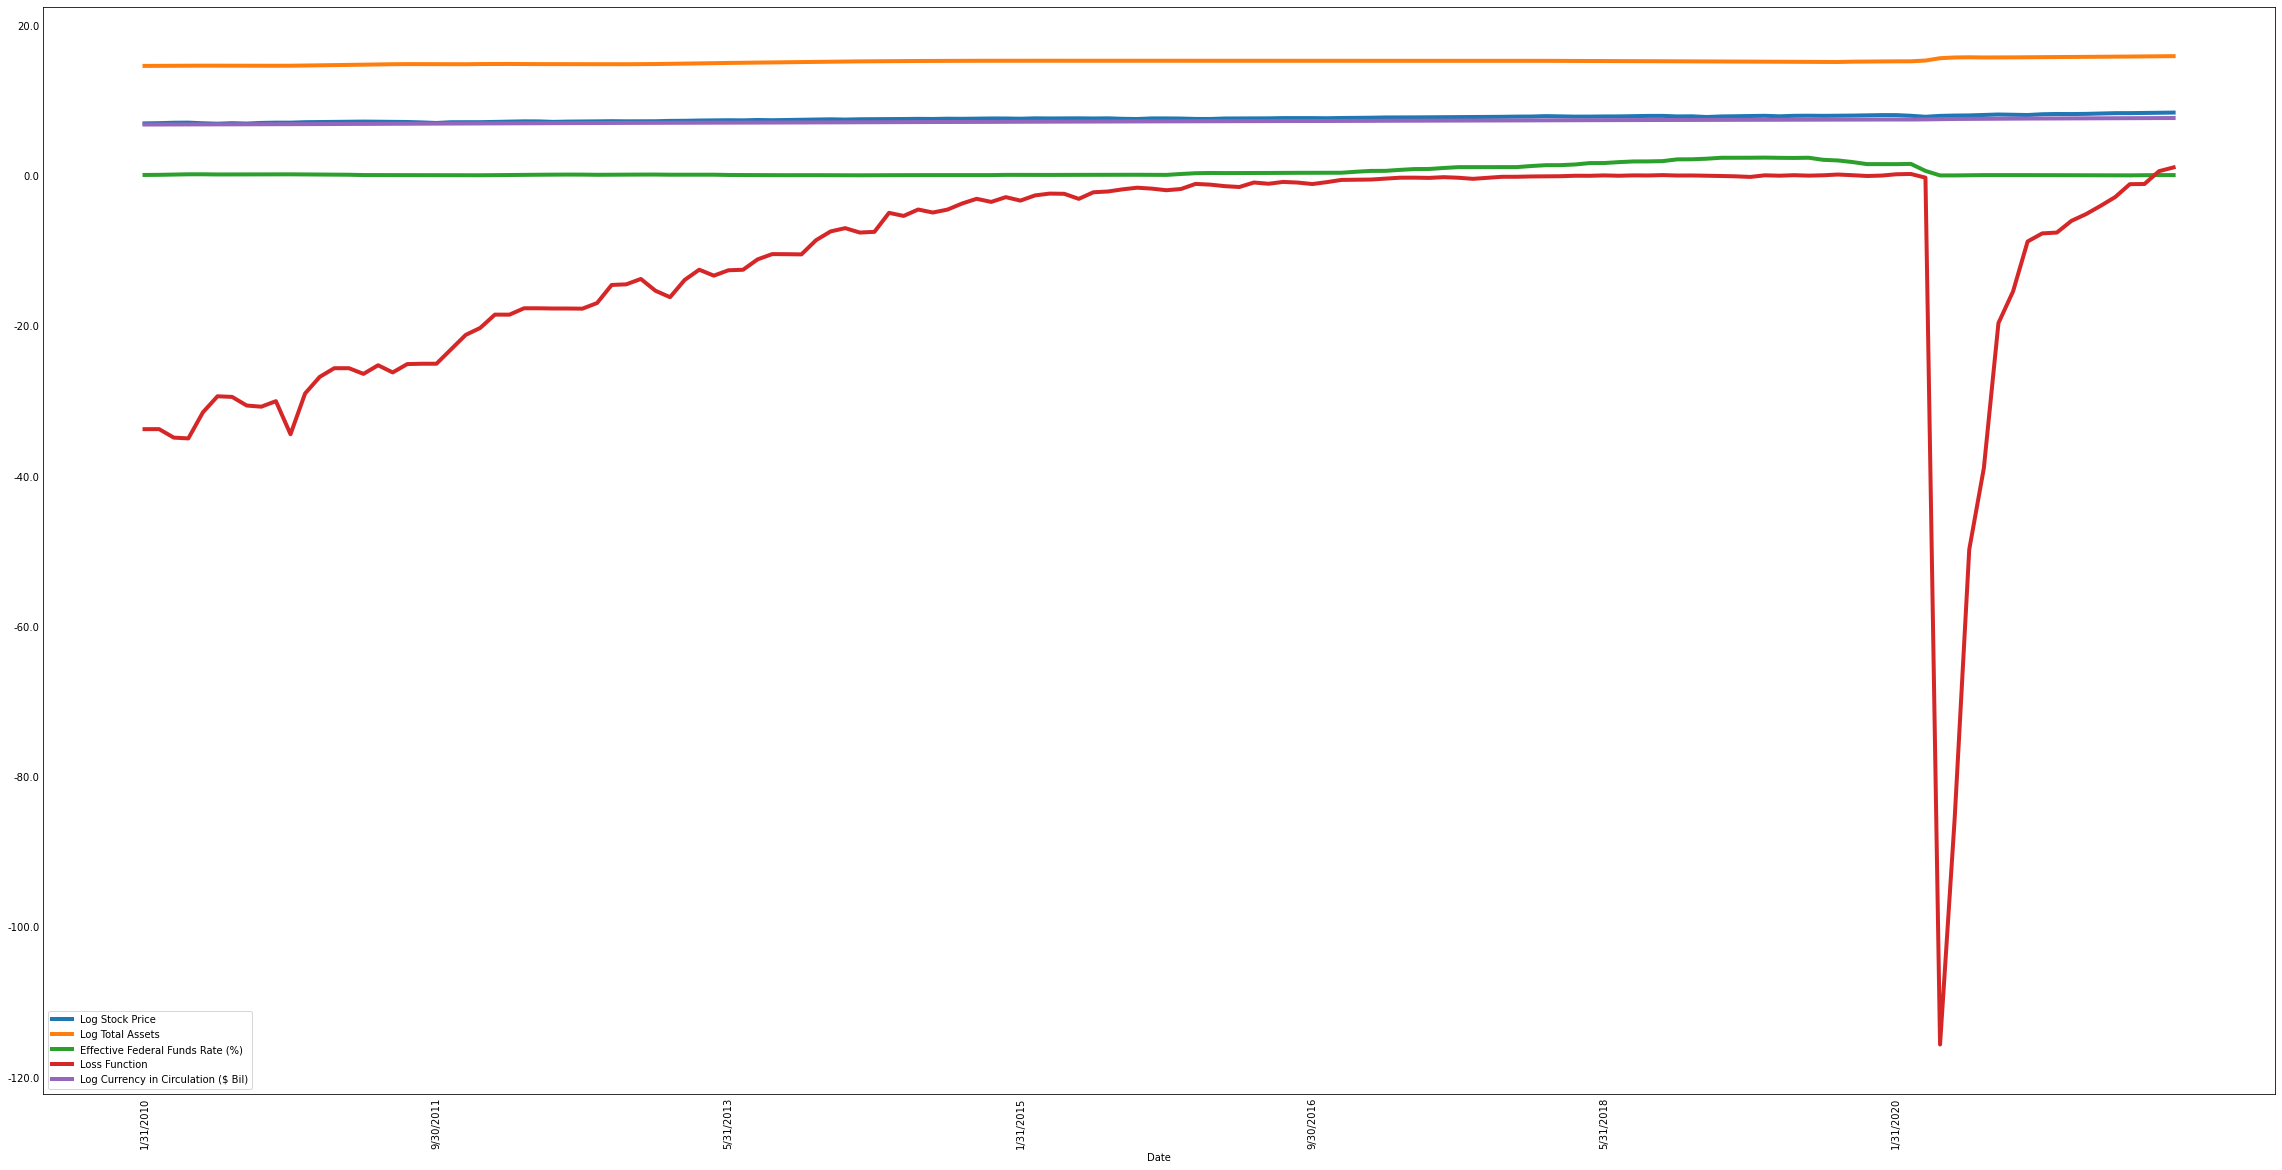

In [7]:
from datlib.plots import * 
plot_variables = ["Log Stock Price", "Log Total Assets", "Effective Federal Funds Rate (%)", "Loss Function", "Log Currency in Circulation ($ Bil)"]
plot_lines(data[plot_variables], linewidth=4)

In [26]:
#1st diff

data_diff = data.diff().dropna()
data_diff

,Log Stock Price,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
2/28/2010,0.028115,0.004863,0.006465,0.016429,0.004993
3/31/2010,0.057133,0.013474,0.005727,0.038088,-1.128591
4/30/2010,0.014651,0.013207,0.002697,0.033817,-0.109031
5/31/2010,-0.085532,0.003456,0.002585,0.002312,3.476322
6/30/2010,-0.055388,0.000292,0.004139,-0.023978,2.135543
...,...,...,...,...,...
4/30/2021,0.051097,0.016607,0.018519,-0.000677,1.172974
5/31/2021,0.005472,0.011624,0.006068,-0.010935,1.711330
6/30/2021,0.021971,0.020092,0.005019,0.019935,0.022682


In [27]:
X = data_diff["Log Stock Price"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -9.877641
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Reject Ho - Time Series is Stationary
ADF Statistic: -3.241101
p-value: 0.017726
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
Reject Ho - Time Series is Stationary
ADF Statistic: -6.592061
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Reject Ho - Time Series is Stationary
ADF Statistic: -3.189065
p-value: 0.020626
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Reject Ho - Time Series is Stationary
ADF Statistic: -7.925039
p-value: 0.000000
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
Reject Ho - Time Series is Stationary


In [28]:
#2nd diff

data_new = data_diff.diff().dropna()
data_new

,Log Stock Price,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
3/31/2010,0.029018,0.008611,-0.000738,0.021659,-1.133584
4/30/2010,-0.042481,-0.000267,-0.003030,-0.004270,1.019559
5/31/2010,-0.100183,-0.009751,-0.000112,-0.031505,3.585353
6/30/2010,0.030143,-0.003164,0.001554,-0.026290,-1.340778
7/31/2010,0.121904,-0.002388,-0.000532,0.029892,-2.219644
...,...,...,...,...,...
4/30/2021,0.009535,-0.002911,0.011371,0.005359,0.070955
5/31/2021,-0.045626,-0.004982,-0.012451,-0.010258,0.538356
6/30/2021,0.016499,0.008468,-0.001048,0.030871,-1.688648


In [29]:
X = data_new["Log Stock Price"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -6.345118
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579
Reject Ho - Time Series is Stationary
ADF Statistic: -8.089740
p-value: 0.000000
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579
Reject Ho - Time Series is Stationary
ADF Statistic: -8.457388
p-value: 0.000000
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578
Reject Ho - Time Series is Stationary
ADF Statistic: -3.698743
p-value: 0.004131
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Reject Ho - Time Series is Stationary
ADF Statistic: -5.560529
p-value: 0.000002
Critical Values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Reject Ho - Time Series is Stationary


In [30]:
data_new.to_csv("s&p10.csv")

In [32]:
df = data_new
df

,Log Stock Price,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
3/31/2010,0.029018,0.008611,-0.000738,0.021659,-1.133584
4/30/2010,-0.042481,-0.000267,-0.003030,-0.004270,1.019559
5/31/2010,-0.100183,-0.009751,-0.000112,-0.031505,3.585353
6/30/2010,0.030143,-0.003164,0.001554,-0.026290,-1.340778
7/31/2010,0.121904,-0.002388,-0.000532,0.029892,-2.219644
...,...,...,...,...,...
4/30/2021,0.009535,-0.002911,0.011371,0.005359,0.070955
5/31/2021,-0.045626,-0.004982,-0.012451,-0.010258,0.538356
6/30/2021,0.016499,0.008468,-0.001048,0.030871,-1.688648


In [33]:
## Johansen test as Cointegration test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Log Stock Price ::  252.53    > 60.0627   =>   True
Log Total Assets ::  167.94    > 40.1749   =>   True
Log Currency in Circulation ($ Bil) ::  104.9     > 24.2761   =>   True
Effective Federal Funds Rate (%) ::  65.82     > 12.3212   =>   True
Loss Function ::  31.27     > 4.1296    =>   True


In [34]:
##Testing Causation using Granger’s Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data_new, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data_new[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Log Stock Price_x,Log Total Assets_x,Log Currency in Circulation ($ Bil)_x,Effective Federal Funds Rate (%)_x,Loss Function_x
Log Stock Price_y,1.0000,0.0018,0.0127,0.0007,0.0161
Log Total Assets_y,0.0000,1.0000,0.0135,0.0000,0.0000
Log Currency in Circulation ($ Bil)_y,0.0031,0.0061,1.0000,0.0000,0.0835
Effective Federal Funds Rate (%)_y,0.0013,0.0007,0.0006,1.0000,0.0002
Loss Function_y,0.0000,0.0000,0.0000,0.0000,1.0000


## VIX

In [63]:
data=pd.read_csv("VIX-raw-10.csv")

In [64]:
data

,Date,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
0,1/31/2010,20.643158,14.629292,6.825715,0.110000,-33.735952
1,2/28/2010,22.540000,14.634155,6.832180,0.126429,-33.730959
2,3/31/2010,17.767391,14.647630,6.837907,0.164516,-34.859550
3,4/30/2010,17.424286,14.660837,6.840604,0.198333,-34.968581
4,5/31/2010,31.929500,14.664293,6.843189,0.200645,-31.492259
...,...,...,...,...,...,...
135,4/30/2021,17.416190,15.866549,7.675462,0.069000,-2.827729
136,5/31/2021,19.760500,15.878174,7.681530,0.058065,-1.116398
137,6/30/2021,16.956818,15.898266,7.686549,0.078000,-1.093716
138,7/31/2021,17.603333,15.918468,7.689882,0.098065,0.611392


In [65]:
data = data.set_index('Date')
data

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
1/31/2010,20.643158,14.629292,6.825715,0.110000,-33.735952
2/28/2010,22.540000,14.634155,6.832180,0.126429,-33.730959
3/31/2010,17.767391,14.647630,6.837907,0.164516,-34.859550
4/30/2010,17.424286,14.660837,6.840604,0.198333,-34.968581
5/31/2010,31.929500,14.664293,6.843189,0.200645,-31.492259
...,...,...,...,...,...
4/30/2021,17.416190,15.866549,7.675462,0.069000,-2.827729
5/31/2021,19.760500,15.878174,7.681530,0.058065,-1.116398
6/30/2021,16.956818,15.898266,7.686549,0.078000,-1.093716


C:\Users\proma.gupta\Desktop\jupyter_practice\ML Tutorial\Updated\datlib\plots.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


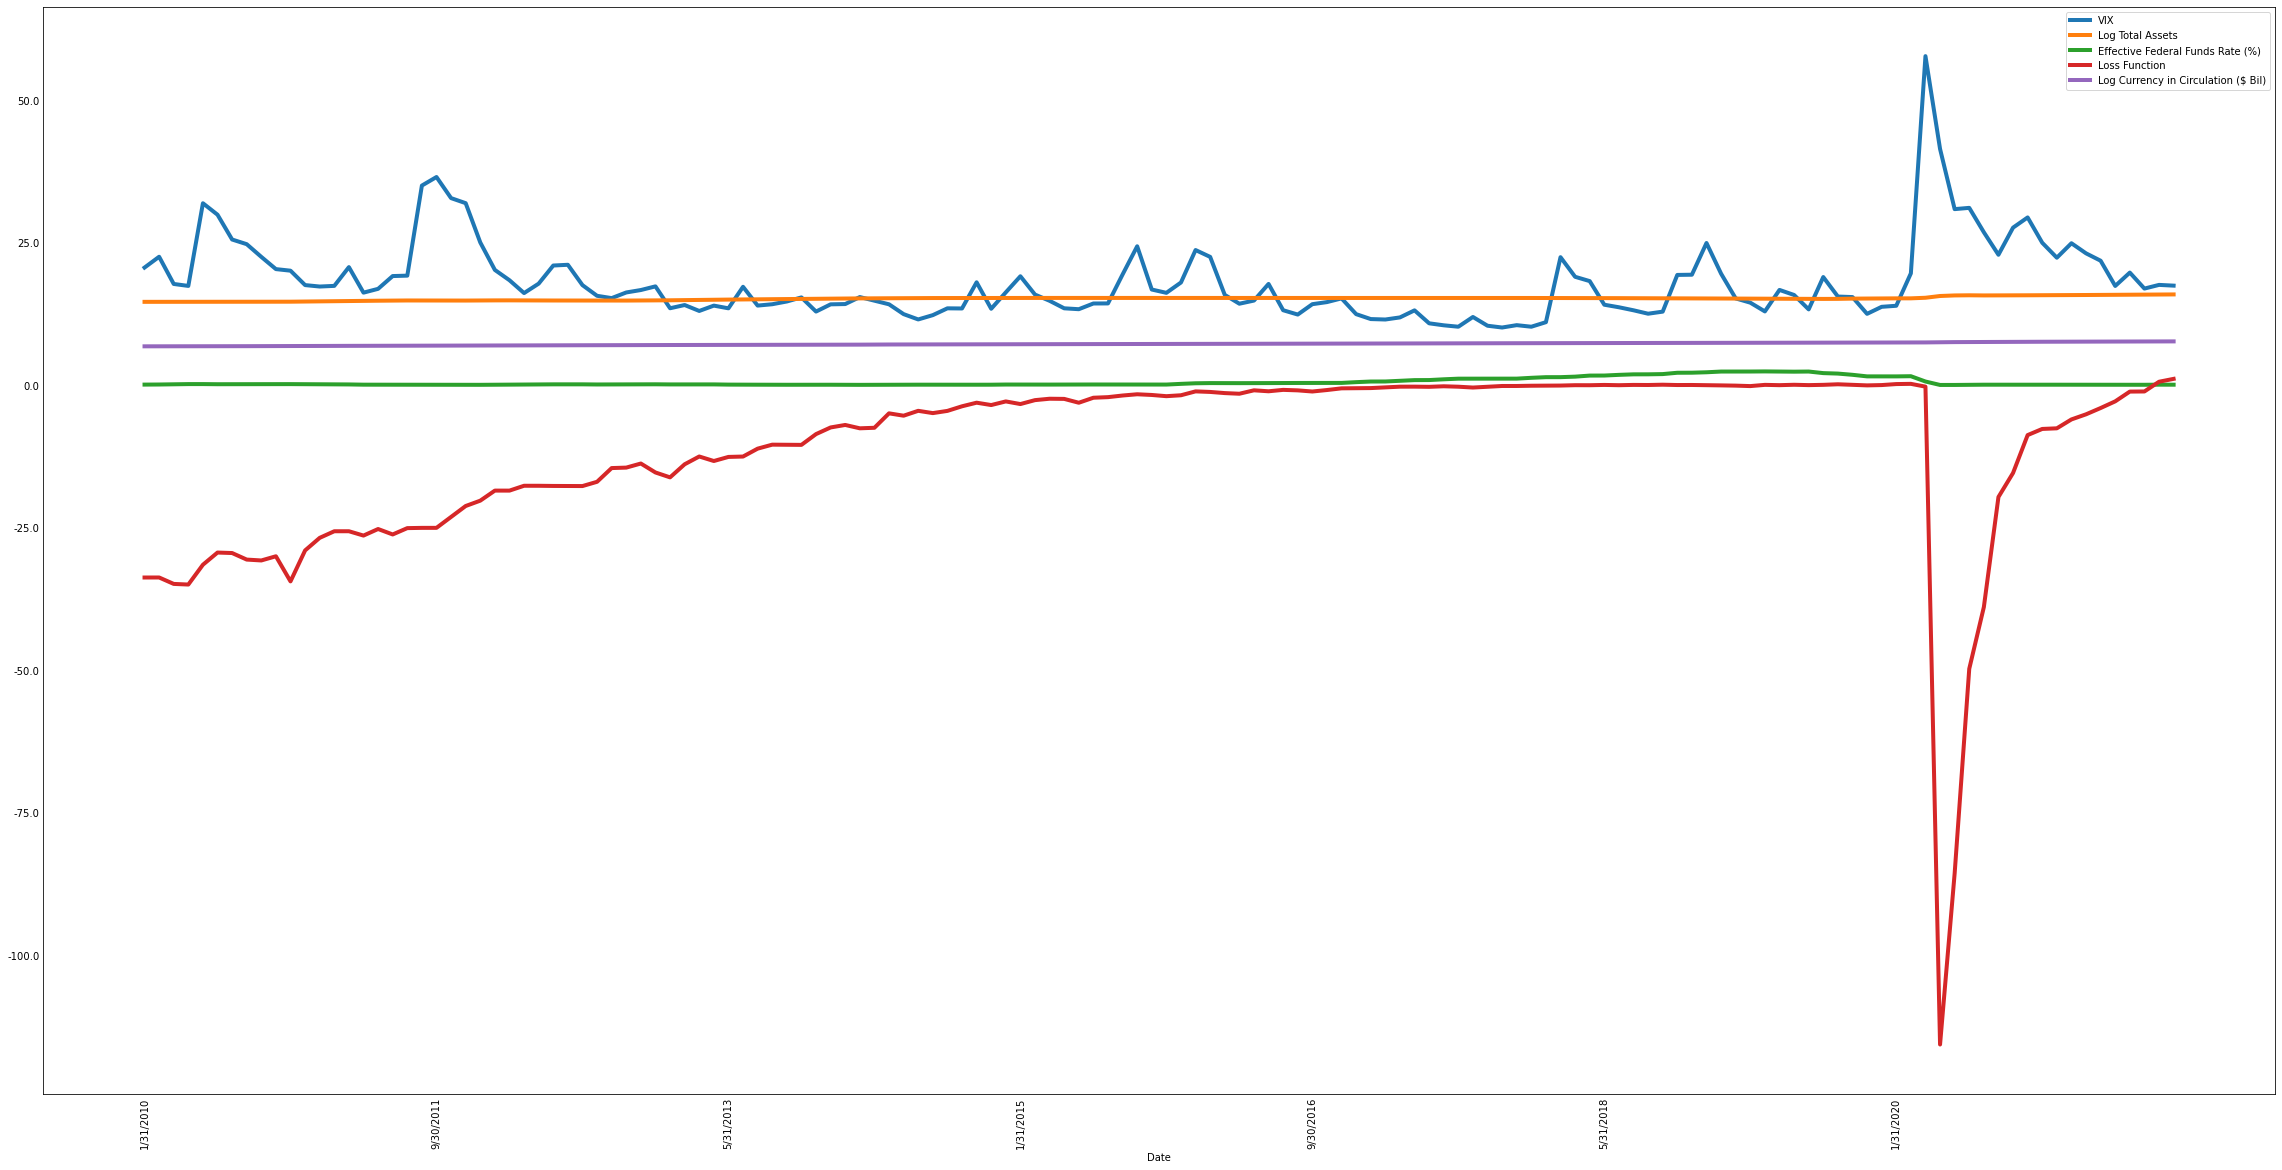

In [66]:
from datlib.plots import * 
plot_variables = ["VIX", "Log Total Assets", "Effective Federal Funds Rate (%)", "Loss Function", "Log Currency in Circulation ($ Bil)"]
plot_lines(data[plot_variables], linewidth=4)

In [67]:
## adf

X = data["VIX"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    

ADF Statistic: -4.642980
p-value: 0.000108
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
Reject Ho - Time Series is Stationary
ADF Statistic: -2.391697
p-value: 0.144094
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -0.277655
p-value: 0.928610
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: 0.407934
p-value: 0.981789
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -4.372012
p-value: 0.000333
Critical Values:
	1%: -3.478
	5%: -2.883
	10%: -2.578
Reject Ho - Time Series is Stationary


In [68]:
data_diff = data.diff().dropna()
data_diff

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
2/28/2010,1.896842,0.004863,0.006465,0.016429,0.004993
3/31/2010,-4.772609,0.013474,0.005727,0.038088,-1.128591
4/30/2010,-0.343106,0.013207,0.002697,0.033817,-0.109031
5/31/2010,14.505214,0.003456,0.002585,0.002312,3.476322
6/30/2010,-2.013136,0.000292,0.004139,-0.023978,2.135543
...,...,...,...,...,...
4/30/2021,-4.426853,0.016607,0.018519,-0.000677,1.172974
5/31/2021,2.344310,0.011624,0.006068,-0.010935,1.711330
6/30/2021,-2.803682,0.020092,0.005019,0.019935,0.022682


In [69]:
data_new = data_diff.diff(year).dropna()

In [70]:
data_new

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
2/28/2011,-1.782342,0.019308,0.001852,-0.028030,1.151841
3/31/2011,8.066087,0.019080,0.007964,-0.056164,1.130635
4/30/2011,-4.136373,0.019844,0.005930,-0.074527,-0.649606
5/31/2011,-13.837786,0.024711,0.004620,-0.006441,-2.326994
6/30/2011,4.254890,0.028663,0.002588,0.022108,-3.090908
...,...,...,...,...,...
4/30/2021,11.856156,-0.293506,-0.014501,0.602581,116.593103
5/31/2021,12.901119,-0.086479,-0.016122,-0.011935,-28.320868
6/30/2021,-3.026227,-0.005519,-0.008181,-0.007731,-35.859618


In [71]:
X = data_new["VIX"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -5.240717
p-value: 0.000007
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -4.018052
p-value: 0.001319
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580
Reject Ho - Time Series is Stationary
ADF Statistic: -3.610666
p-value: 0.005560
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580
Reject Ho - Time Series is Stationary
ADF Statistic: -5.642174
p-value: 0.000001
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580
Reject Ho - Time Series is Stationary
ADF Statistic: -5.091600
p-value: 0.000015
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580
Reject Ho - Time Series is Stationary


In [72]:
df = data_new
df

,VIX,Log Total Assets,Log Currency in Circulation ($ Bil),Effective Federal Funds Rate (%),Loss Function
Date,,,,,
2/28/2011,-1.782342,0.019308,0.001852,-0.028030,1.151841
3/31/2011,8.066087,0.019080,0.007964,-0.056164,1.130635
4/30/2011,-4.136373,0.019844,0.005930,-0.074527,-0.649606
5/31/2011,-13.837786,0.024711,0.004620,-0.006441,-2.326994
6/30/2011,4.254890,0.028663,0.002588,0.022108,-3.090908
...,...,...,...,...,...
4/30/2021,11.856156,-0.293506,-0.014501,0.602581,116.593103
5/31/2021,12.901119,-0.086479,-0.016122,-0.011935,-28.320868
6/30/2021,-3.026227,-0.005519,-0.008181,-0.007731,-35.859618


In [73]:
data_new.to_csv("VIX-10-diff-2.csv")

In [74]:
## Johansen test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
VIX    ::  143.95    > 60.0627   =>   True
Log Total Assets ::  82.79     > 40.1749   =>   True
Log Currency in Circulation ($ Bil) ::  44.28     > 24.2761   =>   True
Effective Federal Funds Rate (%) ::  24.48     > 12.3212   =>   True
Loss Function ::  10.71     > 4.1296    =>   True


In [75]:
##Testing Causation using Granger’s Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data_new, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data_new[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,VIX_x,Log Total Assets_x,Log Currency in Circulation ($ Bil)_x,Effective Federal Funds Rate (%)_x,Loss Function_x
VIX_y,1.0,0.0000,0.0054,0.0,0.0000
Log Total Assets_y,0.0,1.0000,0.0020,0.0,0.0000
Log Currency in Circulation ($ Bil)_y,0.0,0.0001,1.0000,0.0,0.0008
Effective Federal Funds Rate (%)_y,0.0,0.0000,0.0000,1.0,0.0000
Loss Function_y,0.0,0.0000,0.0000,0.0,1.0000
